# PMOIRED example #2: FU Ori (GRAVITY)

Based on GRAVITY spectro-inteforometric data presented in [Liu et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...884...97L/abstract). This example developes more advanced use of PMOIRED: 

- Loading oifits files containing more than one instrument
- Binning spectroscopic data when the spectral resolution is not needed
- Displaying chromatic data as function of wavelength
- Combining components to make a complex model, with chromatic variation 
- Exploration of parameters using a grid of fit

*https://github.com/amerand/PMOIRED - Antoine Mérand (amerand@eso.org)*

In [1]:
%pylab notebook
import time, os, pickle
try:
    # -- global installation
    import pmoired
    print('global')
except:
    # -- local installation
    import sys
    sys.path = ['../pmoired'] + sys.path
    import __init__ as pmoired
    print('local')

Populating the interactive namespace from numpy and matplotlib
[P]arametric [M]odeling of [O]ptical [I]nte[r]ferom[e]tric [D]ata https://github.com/amerand/PMOIRED
cheking for newer version... Up to date [you have 20211028]
local


## List and load data
OIFITS files can contain data from different targets and instruments. The constructor for `OI` can be set to load data from a specific instrument / target by using keyword arguments `insname` and `targname`. If the file contain more than one target and no `targname` is specified, then the loading will fail. On the other hand, if a single target is present but many instruments, all instruments will be loaded in separate dictionnaries.

For this particular case, we do not really use the spectral resoution, but still require some chromatique information. This is a good case to use the `binning` option when loading data, which will optimally bin data (based on their error). `binning=5` means that spectral information will be reduced by a factor of 5.

In [2]:
directory = './FUOri'
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('singlesciviscalibrated.fits')]
# -- load only spectrograph
oi = pmoired.OI(files, insname='GRAVITY_SC', binning=5)

loadOI: loading ./FUOri/GRAVI.2016-11-25T06_27_33.893_singlescivis_singlesciviscalibrated.fits
  > insname: "GRAVITY_SC" targname: "FU_Ori" pipeline: "GRAVITY Instrument Pipeline 1.0.11"
  > MJD: (1,) [ 57717.27102101271 .. 57717.27102101271 ]
  > D0-G2-J3-K0 | WL: (42,) [ 1.99 .. 2.45 ] um (R~202) (binned by x5) {'OI_FLUX': 4, 'OI_T3': 4, 'OI_VIS': 6, 'OI_VIS2': 6} | | TELL: False
loadOI: loading ./FUOri/GRAVI.2016-11-25T06_39_21.933_singlescivis_singlesciviscalibrated.fits
  > insname: "GRAVITY_SC" targname: "FU_Ori" pipeline: "GRAVITY Instrument Pipeline 1.0.11"
  > MJD: (1,) [ 57717.27925017938 .. 57717.27925017938 ]
  > D0-G2-J3-K0 | WL: (42,) [ 1.99 .. 2.45 ] um (R~202) (binned by x5) {'OI_FLUX': 4, 'OI_T3': 4, 'OI_VIS': 6, 'OI_VIS2': 6} | | TELL: False


## Fit a multi-components model 
The model is composed of two components: a "compact" component and a "resolved" one. Making a composite model is very easy to achieve: the model is still described by a dictionnary, but parameters are grouped by components as `component,param`.

The compat component is used as the phase and flux reference: it has central position `x, y = 0, 0` (because by default, if no position is give, it will be placed at '0,0'). We have to fix the flux somehow, since interferometry if not sensitive to absolute fluxes. This is achieved by adding `compact,f0` to `doNotFit`. 

When we look at the result with the `show` method, we can display all data (`allInOne=True`) with the model as function of the wavelength (i.e. `spectro=True`, set automatically). A synthetic image is computed when a field-of-view `imFov` and pixel size `imPix` are given (both in mas). In this particular case, the extended component has very low surface brightness. To make is visible in the synthetic image, the image is shown only between 0 and `imMax=0.002`.

[dpfit] 6 FITTED parameters: ['compact,ud', 'resolved,F0', 'resolved,F2', 'resolved,fwhm', 'resolved,x', 'resolved,y']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] number of function call: 65
[dpfit] time per function call: 1.798 (ms)
# -- degrees of freedom: 718
# -- reduced chi2: 0.5847660645216474
{'compact,ud':       1.057, # +/- 0.010
'resolved,F0':      0.02513, # +/- 0.00100
'resolved,F2':      0.4697, # +/- 0.0072
'resolved,fwhm':    8.01, # +/- 0.12
'resolved,x':       -2.27, # +/- 0.19
'resolved,y':       3.79, # +/- 0.16
'compact,f0':       1.0,
'resolved,spectrum':'$F0 + $F2*($WL-2.0)**2',
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
                  0   1   2   3   4   5  
 0:   compact,ud ### -76   6   1   3  21 
 1:  resolved,F0 -76 ### -54   0  -5 -16 
 2:  resolved,F2   6 -54 ###  -5   8 -17 
 3:resolved,fwhm   1   0  -5 ###  -3  15

<IPython.core.display.Javascript object>


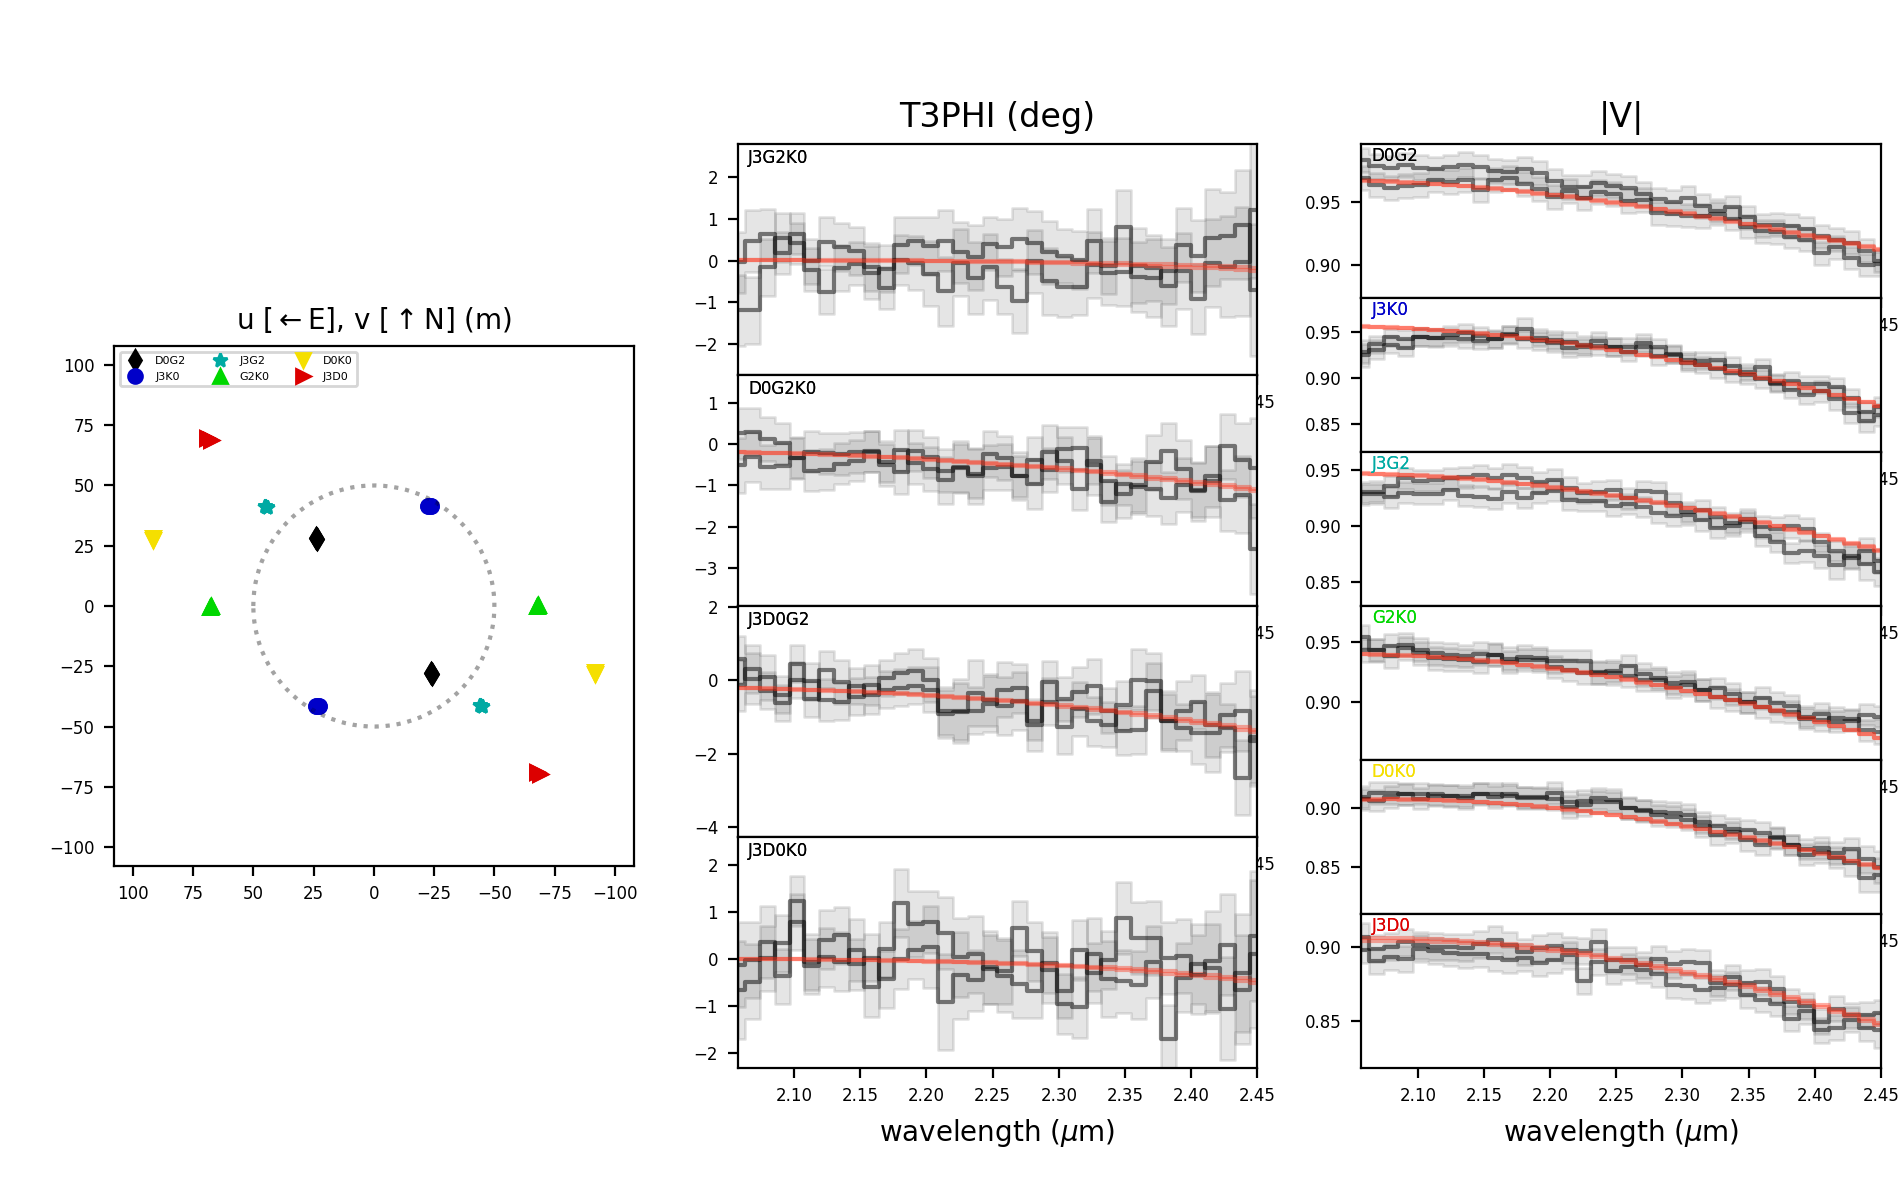

<IPython.core.display.Javascript object>


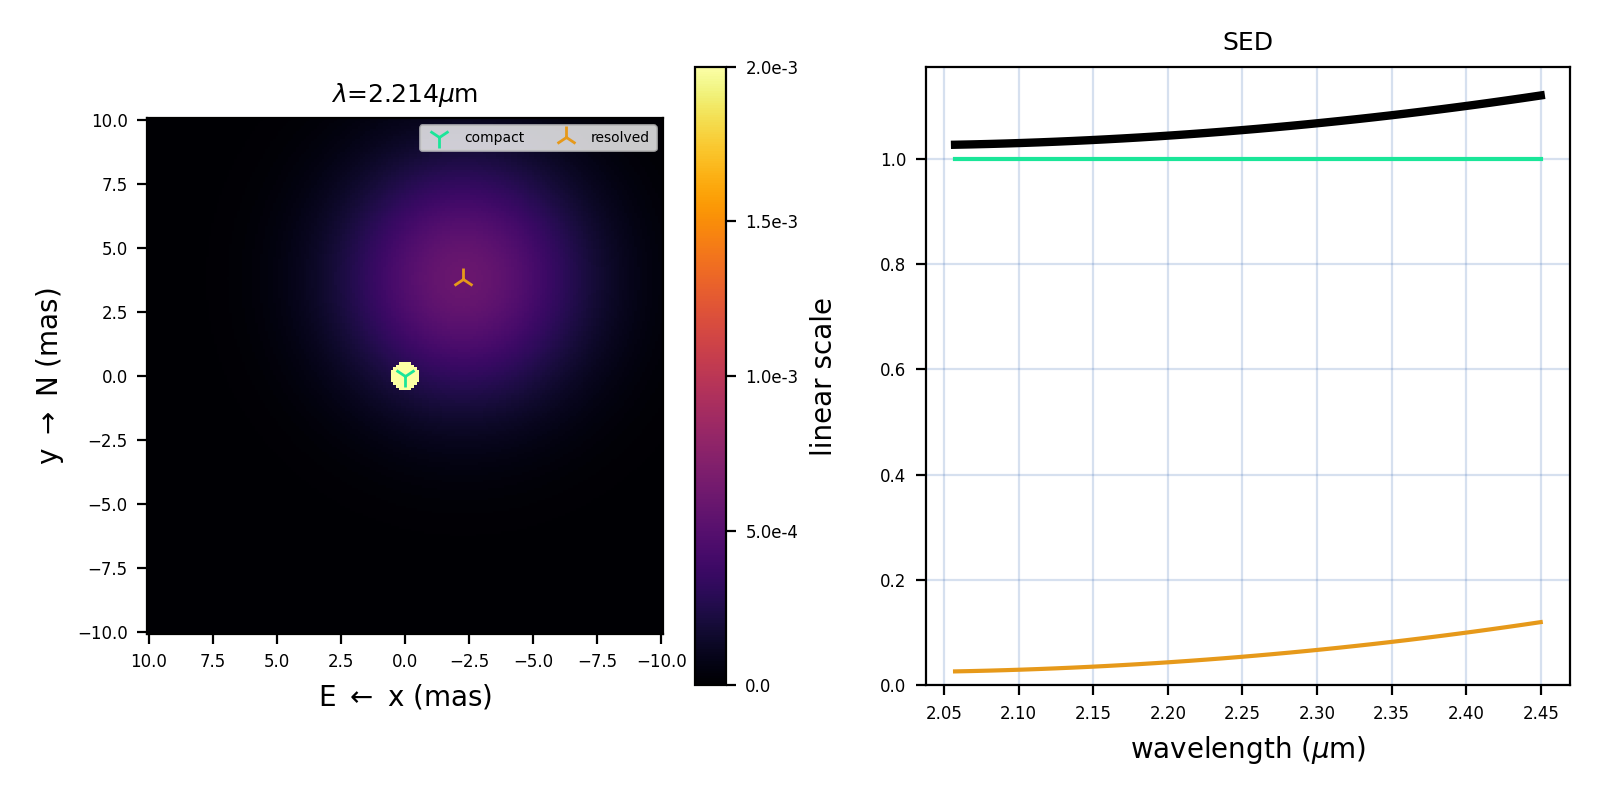

In [3]:
# -- set the context for the fit
fit = {
    # -- observable to fit
    'obs': ['|V|','T3PHI'],
    # -- wavelength range: bluest part is noisy
    'wl ranges':[(2.05, 2.5)],
    # -- minimum error, override the errors in data file if it is smaller
    'min error': {'T3PHI':0.5},
    'min relative error':{'|V|':0.01},
}

oi.setupFit(fit)

# -- first guess for the model
param = {'compact,f0':   1.0, # flux of compact component
         'compact,ud':   .5, # uniform disk diameter (mas)
         'resolved,F0':   0.05,  # resolved component flux
         'resolved,F2':   0.5, # resolved component flux in (lambda-min(lambda))**2
         'resolved,spectrum': '$F0 + $F2*($WL-2.0)**2',
         'resolved,fwhm': 5.0,  # resolved component has a gaussian profile, this is its full width half maximum (mas)
         'resolved,x':    0, # offset to E (mas)
         'resolved,y':    0, # offset to N (mas)
        }
doNotFit = ['compact,f0']

# -- using 'merged' because computations are faster:
oi.doFit(param, doNotFit=doNotFit)
# -- using 'data' will show each file separatly
oi.show(allInOne=1, imFov=20, imPix=0.1, imMax=0.002)

## Explore the possible position of the extended component
`gridFit` allows to explore systematically or randomly several parameters to make sure the global minimum is found. The exploration patern is given by the dictionnary `expl`. This nested dictionnary contains ranges for `grid`, `rand` (uniform) or `randn` (normal):
- grid: (min, max, step): explore all values for "min" to "max" with "step"
- rand: (min, max): uniform randomized parameter
- randn: (mean, std): normaly distributed parameter

if any `grid` is defined, the ranges will set the number of total fit, otherwise it must be explicitely given as `Nfits=`. The starting values of other parameters can be given as `param={...}`, or the last fit will be used.

The method `showGrid` allows to show a 2D map of the initial and fitted parameters The global minima is shown as a circled dot. By default, the colors are assigned to $\chi^2$, but can be assigned to another fitted parameter. 

Although  `showGrid` only displays 2 parameters, `gridFit` can be used with more parameters! be aware that defining many `grid` parameters will increase rapidly the nomber of fit required. The fits are parallelized and will by defauly use all the CPU cores available: `multi=N` will limit to `N` cores.

It should be noted that, in this case, the position of the resolved is poorly constrained: this is because we lack a good u,v coverage. The position we find is not the one reported in the article, as no search was performed for that work...

Thu Nov  4 16:16:51 2021: running 121 fits on 8 processes
  one fit takes ~0.41s [~146.6 fit/minute]
Thu Nov  4 16:16:54 2021: approx 46.3s remaining
Thu Nov  4 16:17:01 2021: it took 10.4s, 0.09s per fit on average [697.7 fit/minutes]
fits to be taken into account: 114 / 121
  1 did not numerically converge
  6 fit[s] have uncertainties larger than the grid's step[s] and will be ignored
unique minima: 21 / 114 [~5.4 first guesses / minima]
  few unique minima -> grid too fine / Nfits too large?
------------
best fit: chi2= 0.543921312118272
{'compact,ud':       1.0593, # +/- 0.0096
'resolved,F0':      0.02571, # +/- 0.00096
'resolved,F2':      0.4550, # +/- 0.0069
'resolved,fwhm':    7.61, # +/- 0.11
'resolved,x':       -6.70, # +/- 0.13
'resolved,y':       -9.61, # +/- 0.12
'compact,f0':       1.0,
'resolved,spectrum':'$F0 + $F2*($WL-2.0)**2',
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
                  0   1   2   3   4   5  
 0:   compact,ud ### -76  10 -12   8  14 
 1:  re

<IPython.core.display.Javascript object>


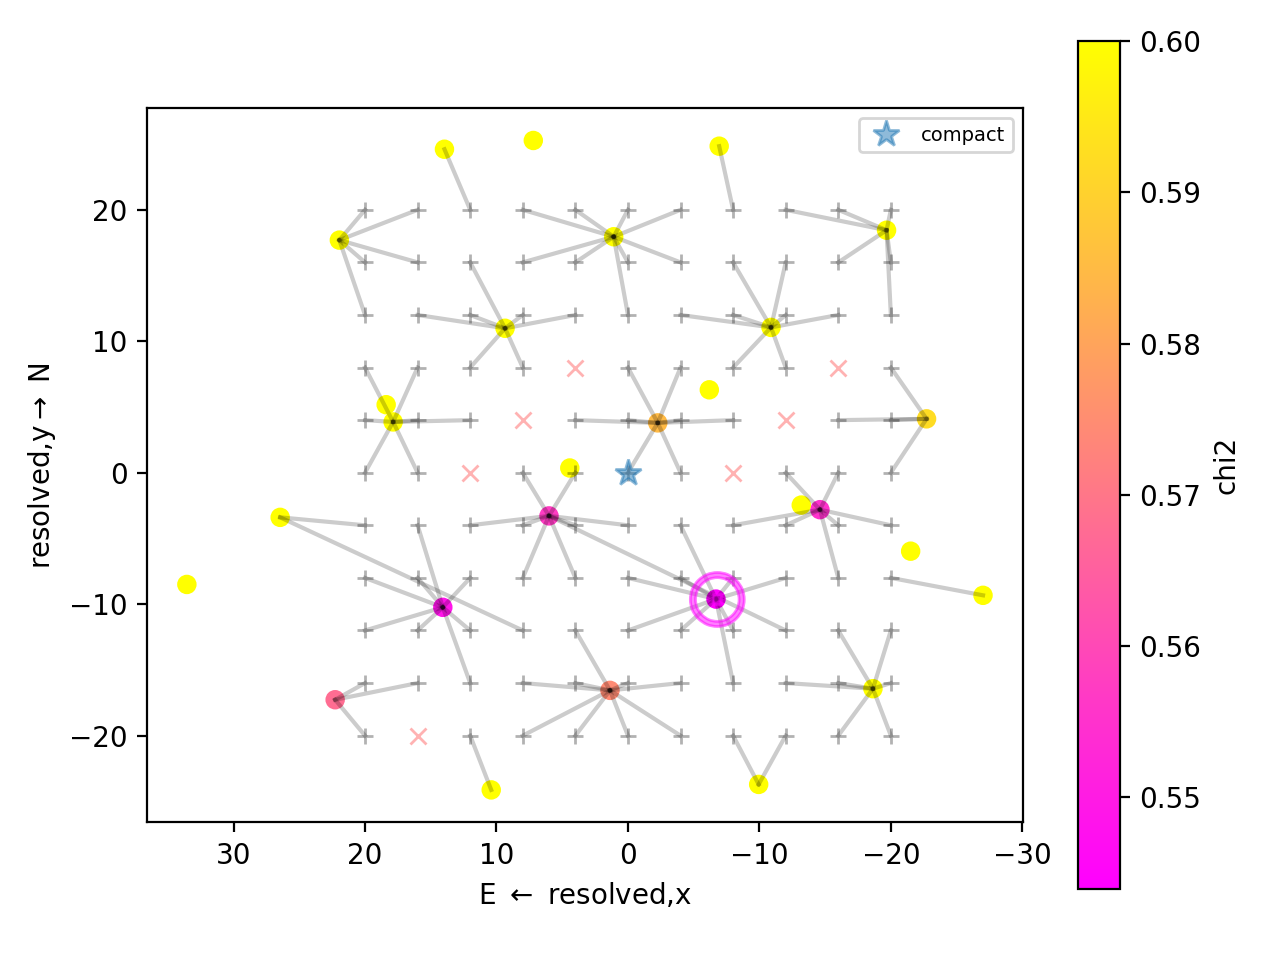

In [4]:
from importlib import reload
reload(pmoired.oimodels)

# -- grid search
expl = {'grid':{'resolved,x': (-20, 20, 4), 'resolved,y':(-20, 20, 4)}}
oi.gridFit(expl)

# -- alternate solution: random exploration
#expl = {'rand':{'resolved,x': (-20, 20), 'resolved,y':(-20, 20)}}
#oi.gridFit(expl, Nfits=64)

oi.showGrid(vmax=0.6)

<IPython.core.display.Javascript object>


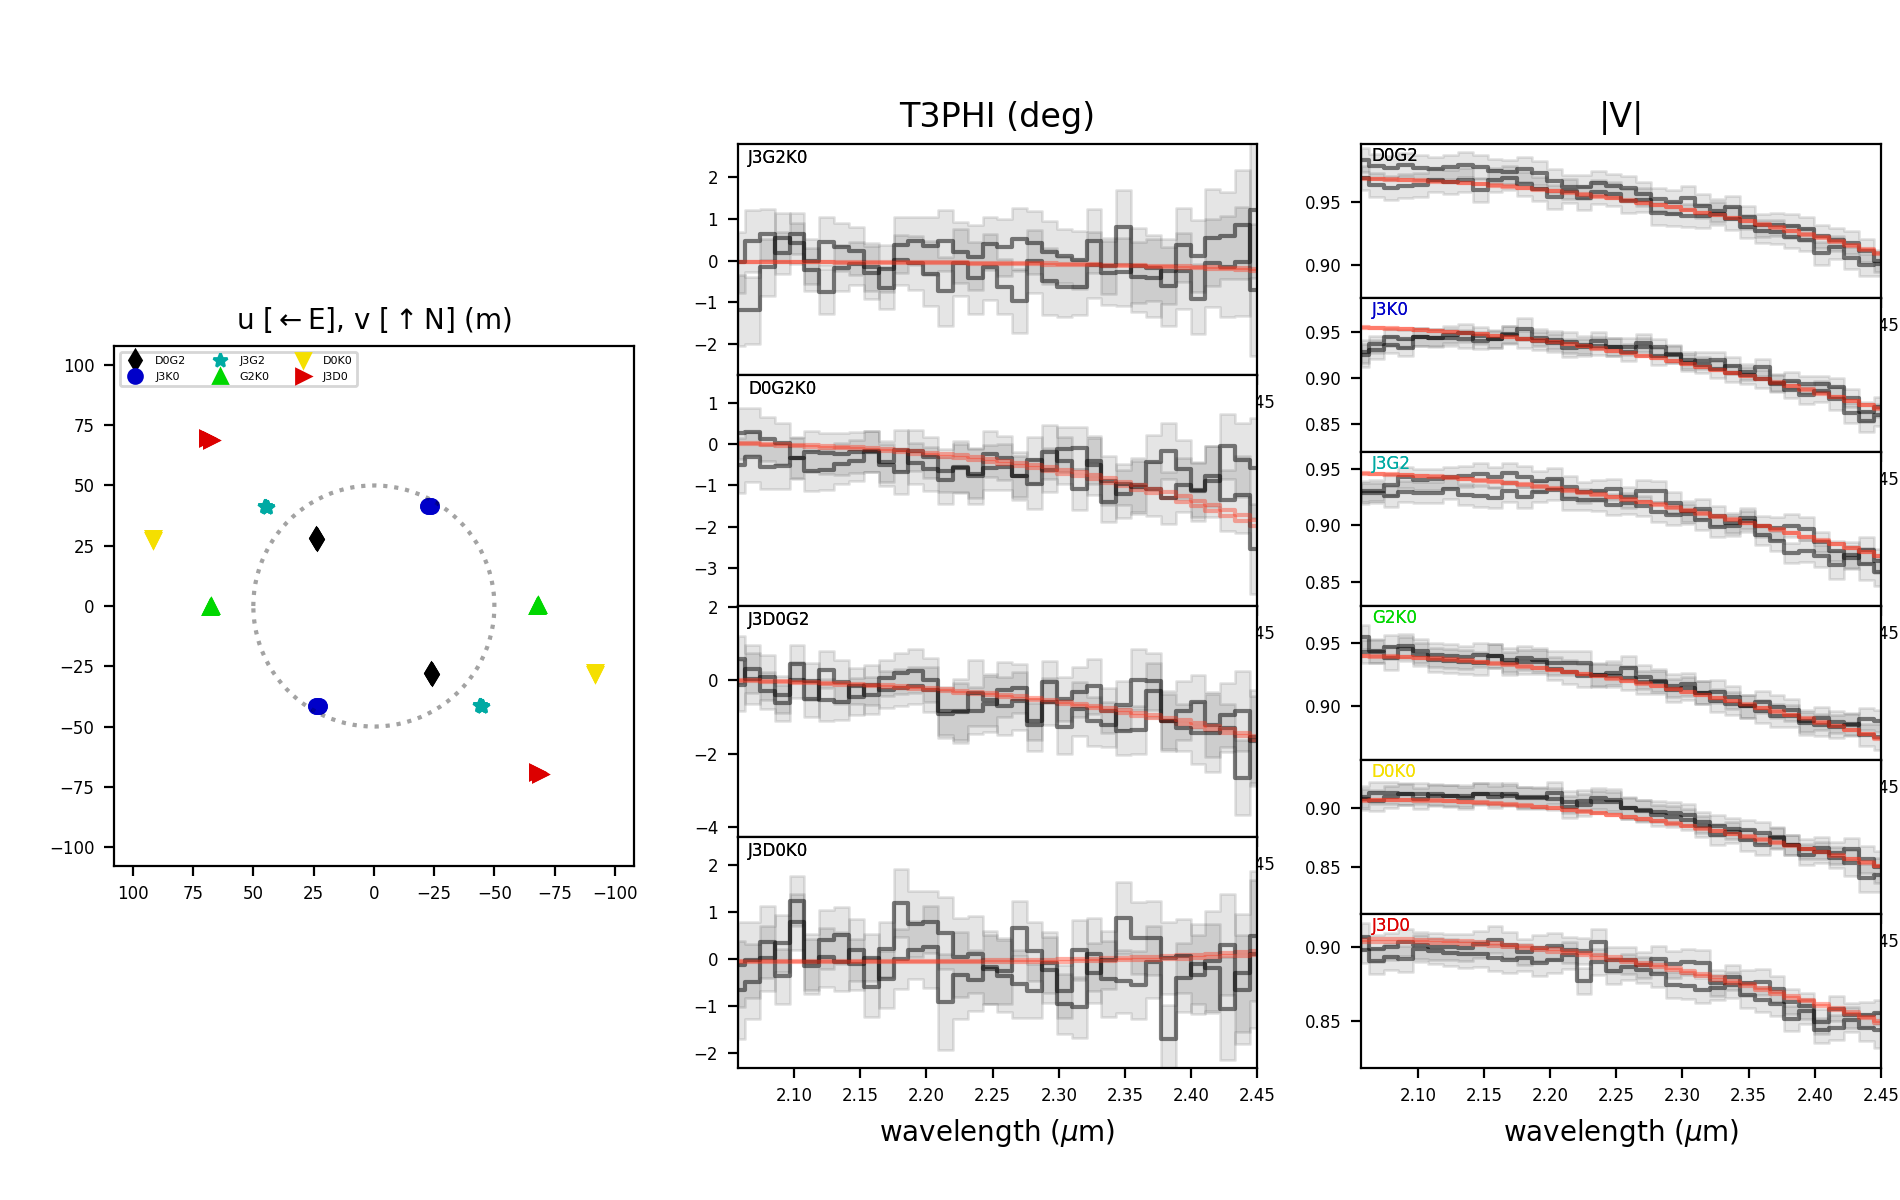

<IPython.core.display.Javascript object>


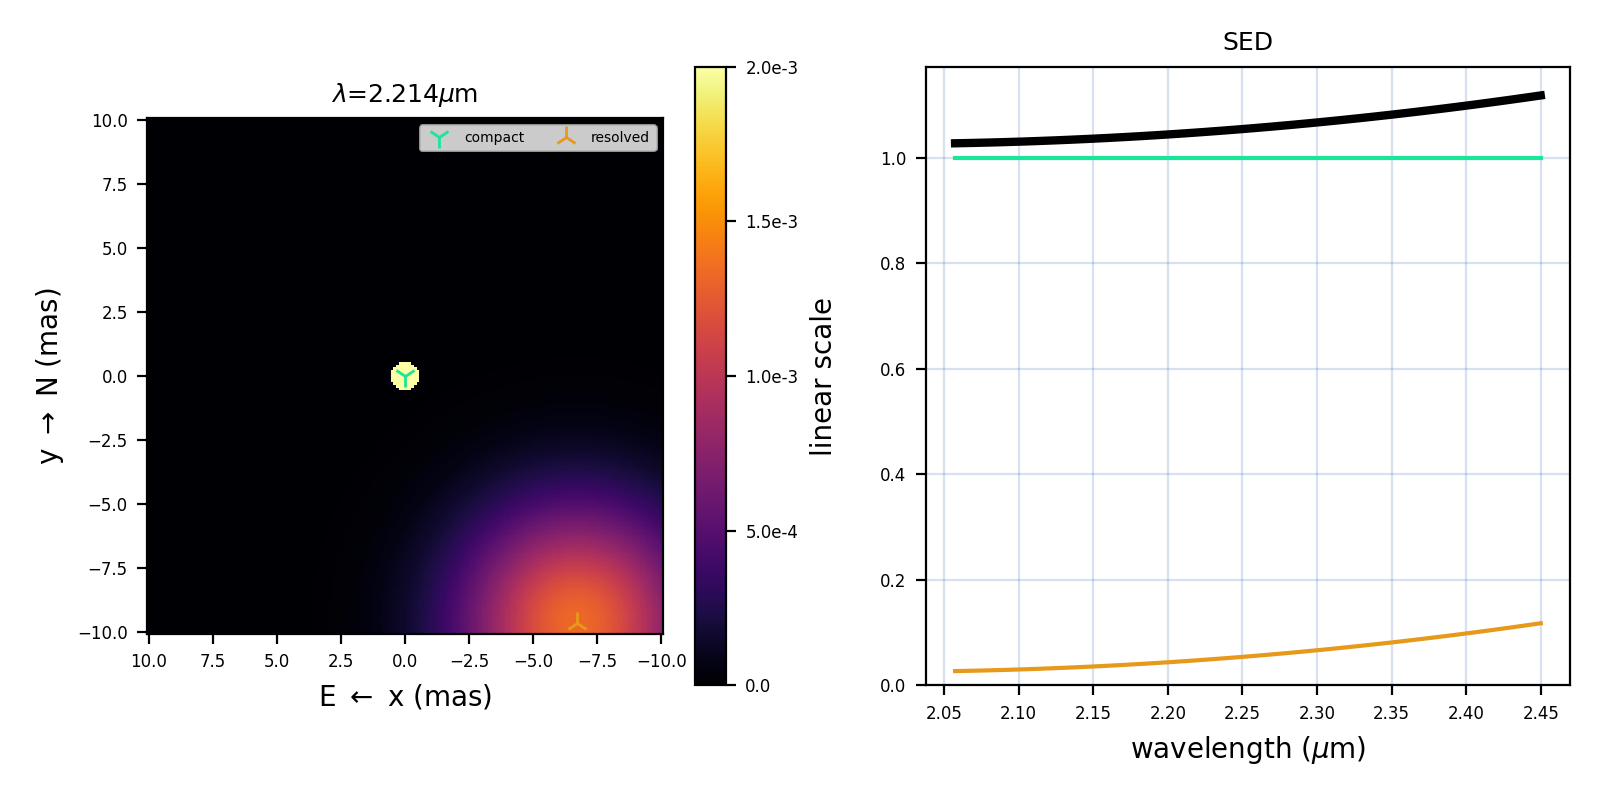

In [5]:
oi.show(allInOne=1, imFov=20, imPix=0.1, imMax=0.002)

## Bootstrapping to get better uncertainties

Contrary to example 1 (Alpha Cen), here the boostrapped uncertainties are much larger that the ones estimated by a simple fit to all data. This is because the model is not robust, or that we do do not have enough data. We also chose to run more fits (`Nfits=200`) than the default number $40 = 2\times(2_\mathrm{epochs}*(6_\mathrm{V2} + 4_\mathrm{T3PHI}))$.

In [6]:
oi.bootstrapFit(Nfits=200)

Thu Nov  4 16:17:02 2021: running 200 fits on 8 processes
  one fit takes ~0.42s [~141.8 fit/minutes]
Thu Nov  4 16:17:06 2021: approx 1.4min remaining
Thu Nov  4 16:17:17 2021: it took 14.6s, 0.07s per fit on average [822.7 fit/minutes]
using 196 fits out of 200 (sigma clipping 4.50)
{'compact,f0'       :1.0 ,
'compact,ud'       : 1.060, # +/- 0.036
'resolved,F0'      : 0.0254, # +/- 0.0033
'resolved,F2'      : 0.4566, # +/- 0.0099
'resolved,fwhm'    : 7.67, # +/- 0.42
'resolved,spectrum':'$F0 + $F2*($WL-2.0)**2',
'resolved,x'       : -6.62, # +/- 0.43
'resolved,y'       : -9.56, # +/- 0.34
}
Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
                  0   1   2   3   4   5  
 0:   compact,ud ### -84  27 -23  -3   3   3 
 1:  resolved,F0 -84 ### -53  24   0   5  25 
 2:  resolved,F2  27 -53 ###  -3   4  -5 -27 
 3:resolved,fwhm -23  24  -3 ###  52  15 -21 
 4:   resolved,x  -3   0   4  52 ### -46 -24 
 5:   resolved,y   3   5  -5  15 -46 ###  -5 


<IPython.core.display.Javascript object>


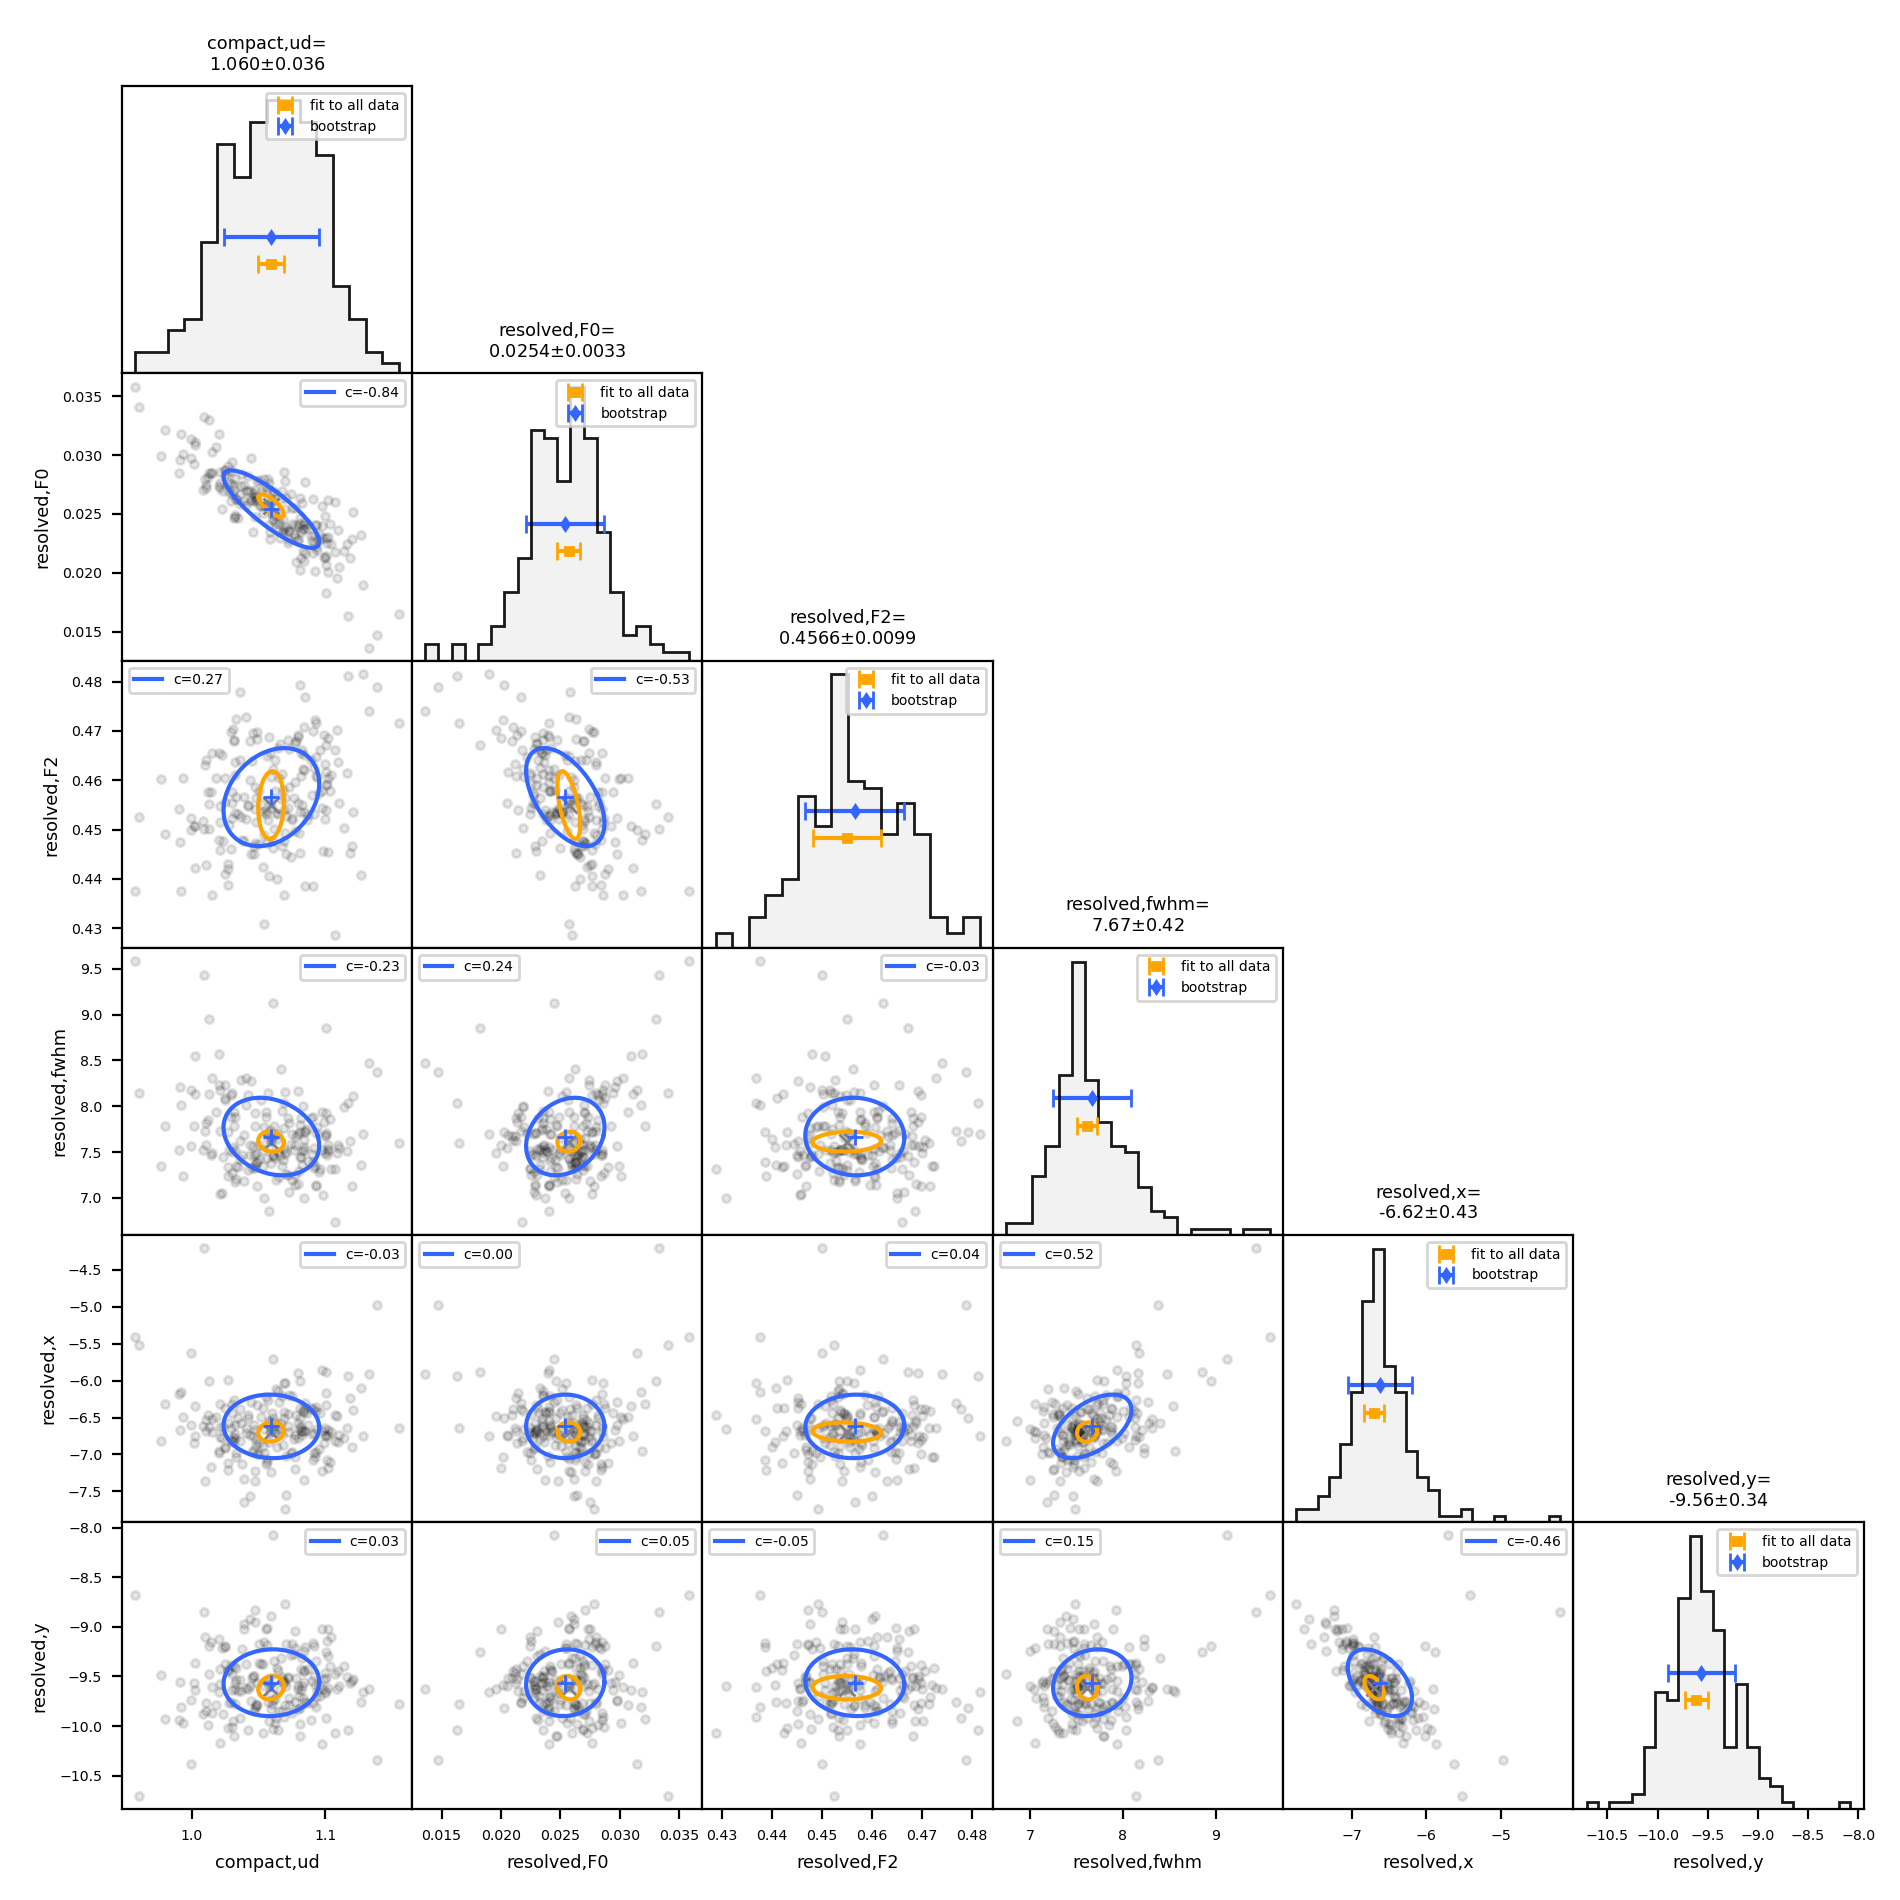

ellipse (emin, emax, PA) for resolved,x/resolved,y: 0.2710 0.4743 -59.2


In [7]:
oi.showBootstrap()

## Alternate model, not in original paper
We still use 2 components. In order to create closure phase signal, the largest component has a slant rather than being off-centred.

[dpfit] 6 FITTED parameters: ['compact,ud', 'resolved,F0', 'resolved,F2', 'resolved,slant', 'resolved,slant projang', 'resolved,ud']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Thu Nov  4 16:17:22 2021 001/000 CHI2: 3.4827e+00|
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] number of function call: 77
[dpfit] time per function call: 1.797 (ms)
# -- degrees of freedom: 718
# -- reduced chi2: 0.5520624107515997
{'compact,ud':            1.1270, # +/- 0.0081
'resolved,F0':           0.01892, # +/- 0.00085
'resolved,F2':           0.4609, # +/- 0.0066
'resolved,slant':        1.00, # +/- 0.14
'resolved,slant projang':44.61, # +/- 7.95
'resolved,ud':           14.42, # +/- 0.16
'compact,f0':            1.0,
'resolved,spectrum':     '$F0 + $F2*($WL-2.0)**2',
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
                           0   1   2   3   4   5  
 0:            compact,ud ### -71  10   2

<IPython.core.display.Javascript object>


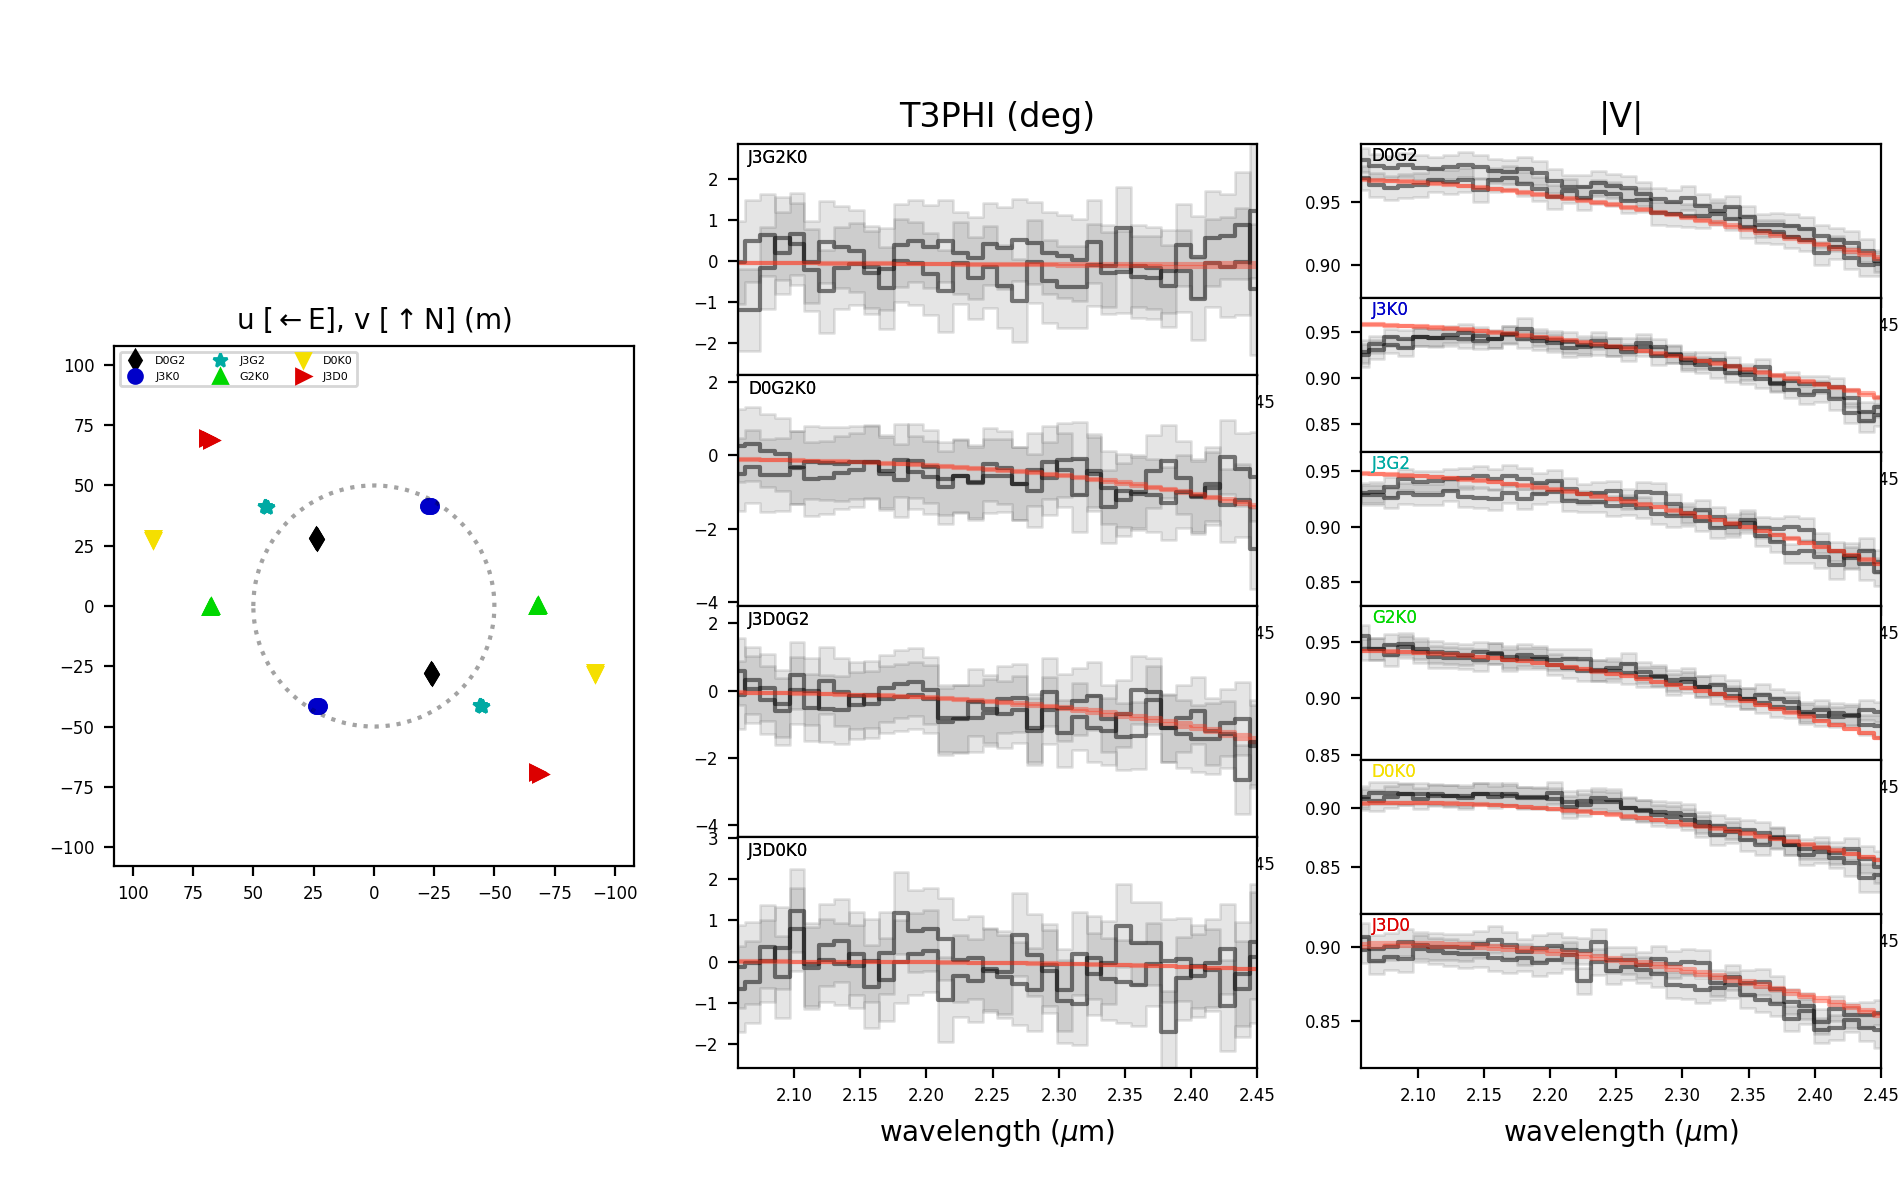

<IPython.core.display.Javascript object>


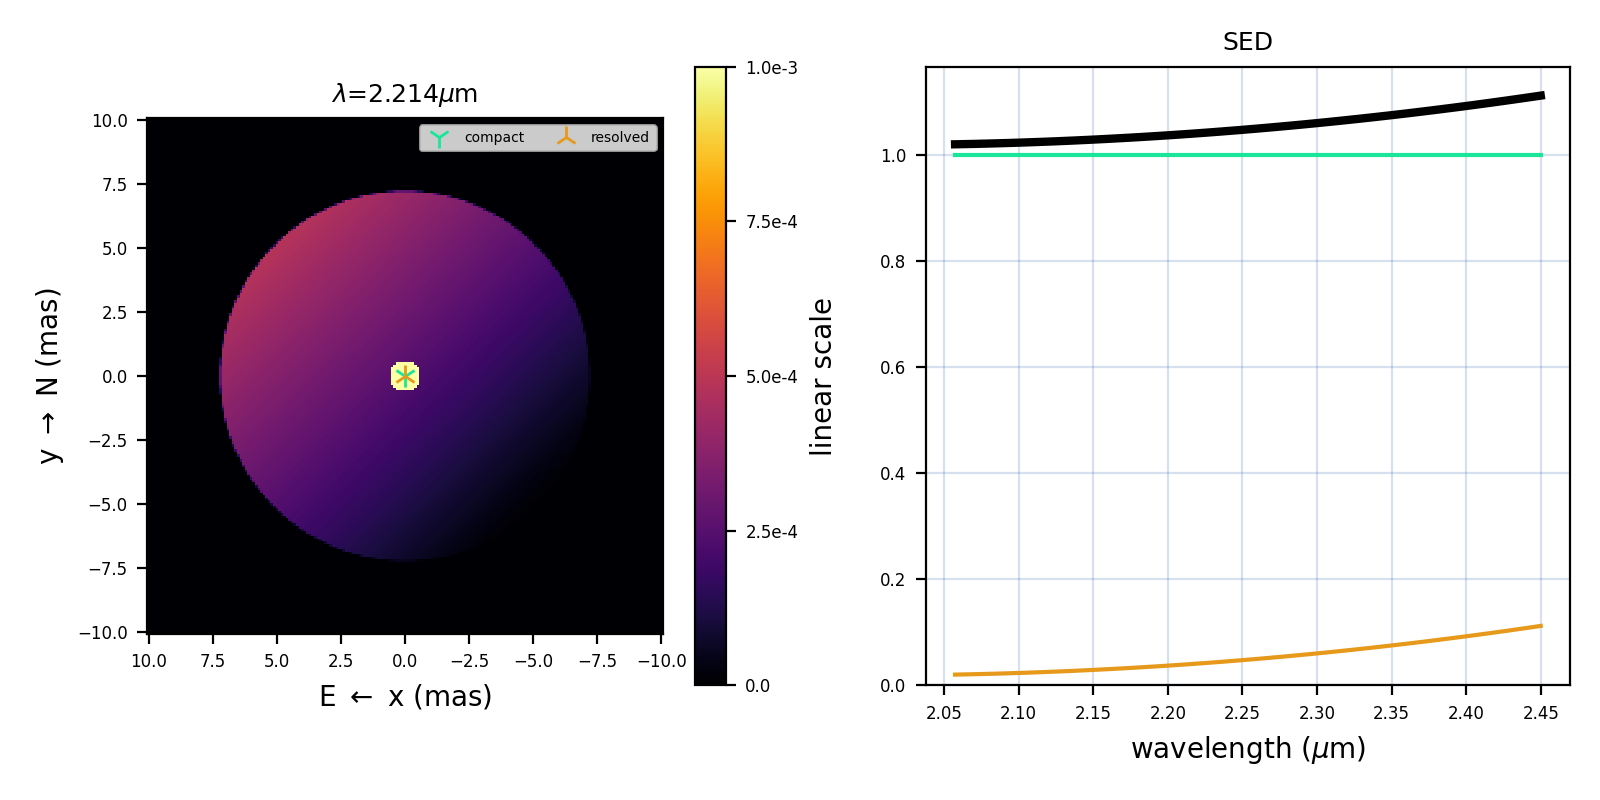

In [8]:
reload(pmoired.oimodels)
# -- set the context for the fit
fit = {
    # -- observable to fit
    'obs': ['|V|','T3PHI'],
    # -- wavelength range: bluest part is very noisy
    'wl ranges':[(2.05, 2.5)],
    # -- minimum error, override the errors in data file
    'min error': {'T3PHI':1.0},
    'min relative error':{'|V|':0.01},
}
oi.setupFit(fit)

param = {'compact,f0':       1.0 ,
         'compact,ud':       1, 
         'resolved,F0':   0.05,  
         'resolved,F2':   0.5, 
         'resolved,spectrum': '$F0 + $F2*($WL-2.0)**2',
          'resolved,slant':    0.5, 
          'resolved,slant projang': 0, 
          'resolved,ud':       10, 
        }
doNotFit = ['compact,f0']
oi.doFit(param, doNotFit=doNotFit)
oi.show(allInOne=True, imFov=20, imPix=0.1, imMax=0.001)